### Import Libraries

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

### Downloading both the files of Normal CT and Abnormal CT from the respective URL

In [2]:
url1 = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url1)

'/home/ndip/data-science/customer-sentimental-analysis/CT-0.zip'

In [3]:
url2 = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-1.zip")
keras.utils.get_file(filename, url2)

'/home/ndip/data-science/customer-sentimental-analysis/CT-1.zip'

In [4]:
os.makedirs("CT_Data")

#folder exists hence the error. Else folder named CT_Data gets created.

FileExistsError: [Errno 17] File exists: 'CT_Data'

In [5]:
with zipfile.ZipFile("CT-0.zip", 'r') as z_fp1:
    z_fp1.extractall("./CT_Data/")
    
with zipfile.ZipFile("CT-1.zip", 'r') as z_fp2:
    z_fp2.extractall("./CT_Data/")

### Load the NiBabel Library 
The following library is used for reading the images which are in .nii format which is a neuroimaging file format.
To read more about it go to the the link: https://nipy.org/nibabel/index.html

In [6]:
!pip install nibabel

In [7]:
import nibabel as nib
from scipy import ndimage

### Data Preprocessing
Basic preprocessing such as resize, rotate and normalization are performed here. More preprocessing can be done based on your requirements

In [18]:
def nib_read(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype('float32')
    return volume

def resize(img):
    # Set the desired depth
    desired_depth = 32
    desired_width = 128
    desired_height = 128
    
    #Current_depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    # Compute depth factor
    final_depth = current_depth / desired_depth
    final_width = current_width / desired_width
    final_height = current_height / desired_height
    depth_factor = 1 / final_depth
    width_factor = 1 / final_width
    height_factor = 1 / final_height
    
    #rotate by 90
    img = ndimage.rotate(img, 90, reshape = False)
    
    #zoom and use spline interpolation of order 1
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order = 1)
    return img
    
def scan_process(fpath):
    volume = nib_read(fpath)
    volume = normalize(volume)
    volume = resize(volume)
    return volume

In [19]:
# normal cases are present in CT-0 with no viral pneumonia
normal_CT_path = [
    os.path.join(os.getcwd(), "CT_Data/CT-0", x) for x in os.listdir("CT_Data/CT-0")]

#abnormal cases are present in CT-23 with signs of viral pneumonia
abnormal_CT_path = [
    os.path.join(os.getcwd(), "CT_Data/CT-23", x) for x in os.listdir("CT_Data/CT-23")]

#count no. of files in each directory
print("CT scans with normal lung tissue: " + str(len(normal_CT_path)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_CT_path)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


### Train and Validation set creation

In [20]:
# Data Preprocess
print("DID IT START")
normal_CT = np.array([scan_process(fpath) for fpath in normal_CT_path])

print("started part2")
abnormal_CT = np.array([scan_process(fpath) for fpath in abnormal_CT_path])
print('STARTED')
# Assign viral cases as ab_labels to 1 and normal cases as n_labels to 0 to make it a binary classification problem
print("HERE")
n_labels = np.array([0 for _ in range(len(normal_CT))])
print("HERE NEXT")
ab_labels = np.array([1 for _ in range(len(abnormal_CT))])

## The print statements were added for myself as I felt that the kernel has frozen :)) Ignore them hahah

DID IT START
started part2
STARTED
HERE
HERE NEXT


In [21]:
# Split data in the ratio 80-20 for training and validation.
x_train = np.concatenate((abnormal_CT[:80], normal_CT[:80]), axis=0)
y_train = np.concatenate((ab_labels[:80], n_labels[:80]), axis=0)
x_val = np.concatenate((abnormal_CT[80:], normal_CT[80:]), axis=0)
y_val = np.concatenate((ab_labels[80:], n_labels[80:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 160 and 40.


### Augmentation on the Fly

In [22]:
import random
from scipy import ndimage

@tf.function
def rotate(volume):
    def scipy_rotate(volume):
        
        angles = [-30, -20, -10, -5, 5, 10, 20, 30]
        angle = random.choice(angles)
        
        volume = ndimage.rotate(volume, angle,reshape = False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume
    augment_rotate = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augment_rotate

def pretrain_process(volume, label):
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def prevalid_process(volume, label):
    volume = tf.expand_dims(volume, axis = 3)
    return volume, label
    

In [23]:
## Data loaders from training and validation
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2

train_data = (train_loader.shuffle(len(x_train)).map(pretrain_process).batch(batch_size).prefetch(2))
valid_data = (valid_loader.shuffle(len(x_val)).map(prevalid_process).batch(batch_size).prefetch(2))

### VIew an Image

Dimension of the CT scan is: (128, 128, 32, 1)


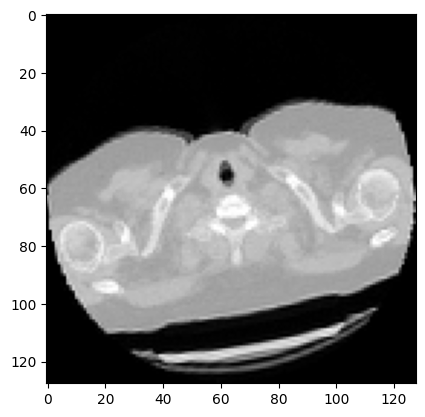

In [29]:
import matplotlib.pyplot as plt

data = train_data.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")


### View multiple Images at once

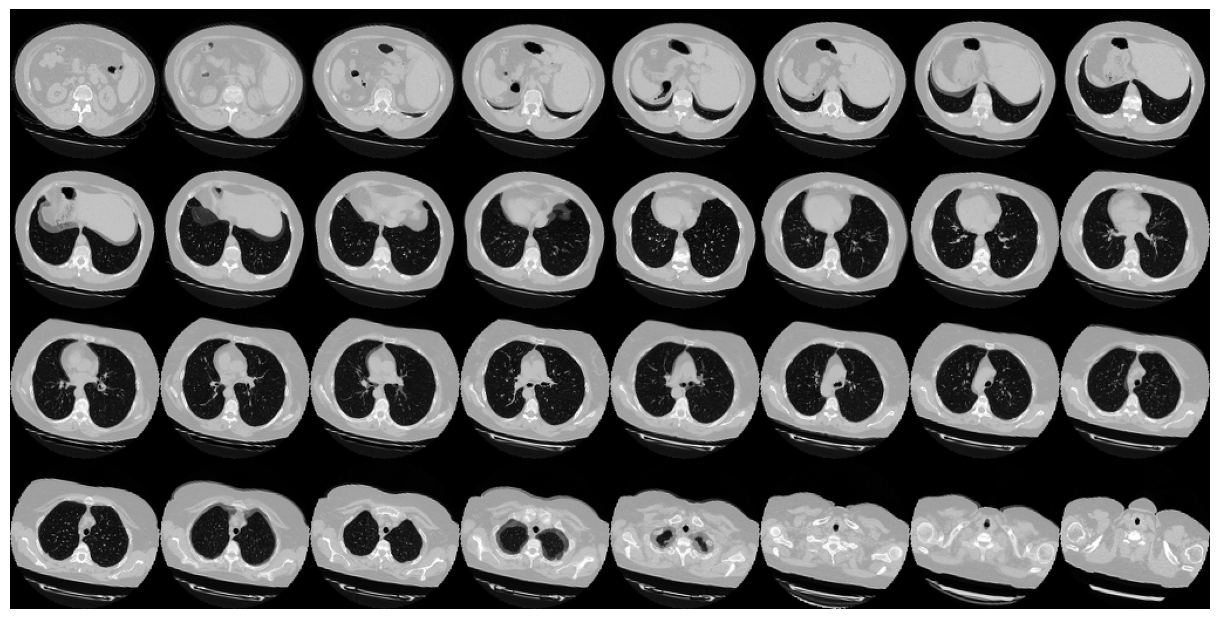

In [32]:

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 8, 128, 128, image[:, :, :40])

### Model Creation
If you wish to read more about the model, kindly read the main paper here: https://arxiv.org/pdf/2007.13224.pdf

In [44]:
def main_model(width, height, depth):
    inputs  =keras.Input((width, height, depth, 1))
    
    x = layers.Conv3D(filters = 64, kernel_size = 3, activation = "relu")(inputs)
    x = layers.MaxPool3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters = 64, kernel_size = 3, activation = "relu")(inputs)
    x = layers.MaxPool3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters = 128, kernel_size = 3, activation = "relu")(inputs)
    x = layers.MaxPool3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters = 256, kernel_size = 3, activation = "relu")(inputs)
    x = layers.MaxPool3D(pool_size = 2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    
    outputs = layers.Dense(1, activation = "softmax")(x)
    
    
    #Define Model
    model = keras.Model(inputs, outputs, name = "3dCNN")
    return model

model = main_model(width = 128, height = 128, depth = 32)
model.summary()
    

Model: "3dCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 32, 1)  0         
                             ]                                   
                                                                 
 conv3d_11 (Conv3D)          (None, 126, 126, 30, 256  7168      
                             )                                   
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 63, 63, 15, 256)  0         
 g3D)                                                            
                                                                 
 batch_normalization_11 (Bat  (None, 63, 63, 15, 256)  1024      
 chNormalization)                                                
                                                                 
 global_average_pooling3d_2   (None, 256)              0     

### Initial Training for 100 epochs

In [45]:
init_learning_rate = 0.0005
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
init_learning_rate, decay_steps = 100000, decay_rate = 0.9, staircase = True)

model.compile(loss = "binary_crossentropy", optimizer = keras.optimizers.Adam(learning_rate = lr_schedule),
             metrics = ['acc'])

checkpoint = keras.callbacks.ModelCheckpoint('3DClassification.h5', save_best_only = True)

#early_stopping = keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 15)
epochs = 100

model.fit(
    train_data,
    validation_data = valid_data,
    epochs = epochs,
    shuffle = True,
    verbose = 2,
    callbacks = [checkpoint],
)

Epoch 1/100
80/80 - 13s - loss: 0.6816 - acc: 0.5000 - val_loss: 0.6914 - val_acc: 0.5000 - 13s/epoch - 158ms/step
Epoch 2/100
80/80 - 13s - loss: 0.6875 - acc: 0.5000 - val_loss: 0.6887 - val_acc: 0.5000 - 13s/epoch - 161ms/step
Epoch 3/100
80/80 - 12s - loss: 0.6481 - acc: 0.5000 - val_loss: 0.7656 - val_acc: 0.5000 - 12s/epoch - 147ms/step
Epoch 4/100
80/80 - 12s - loss: 0.6749 - acc: 0.5000 - val_loss: 0.7310 - val_acc: 0.5000 - 12s/epoch - 147ms/step
Epoch 5/100
80/80 - 12s - loss: 0.6618 - acc: 0.5000 - val_loss: 0.6770 - val_acc: 0.5000 - 12s/epoch - 153ms/step
Epoch 6/100
80/80 - 12s - loss: 0.6653 - acc: 0.5000 - val_loss: 0.7870 - val_acc: 0.5000 - 12s/epoch - 153ms/step
Epoch 7/100
80/80 - 12s - loss: 0.6826 - acc: 0.5000 - val_loss: 0.8251 - val_acc: 0.5000 - 12s/epoch - 150ms/step
Epoch 8/100
80/80 - 12s - loss: 0.6750 - acc: 0.5000 - val_loss: 3.2764 - val_acc: 0.5000 - 12s/epoch - 150ms/step
Epoch 9/100
80/80 - 12s - loss: 0.6924 - acc: 0.5000 - val_loss: 1.4691 - val_ac

Epoch 72/100
80/80 - 12s - loss: 0.6561 - acc: 0.5000 - val_loss: 0.6206 - val_acc: 0.5000 - 12s/epoch - 148ms/step
Epoch 73/100
80/80 - 12s - loss: 0.6497 - acc: 0.5000 - val_loss: 0.6354 - val_acc: 0.5000 - 12s/epoch - 148ms/step
Epoch 74/100
80/80 - 12s - loss: 0.6623 - acc: 0.5000 - val_loss: 0.6267 - val_acc: 0.5000 - 12s/epoch - 148ms/step
Epoch 75/100
80/80 - 12s - loss: 0.6612 - acc: 0.5000 - val_loss: 0.6168 - val_acc: 0.5000 - 12s/epoch - 148ms/step
Epoch 76/100
80/80 - 12s - loss: 0.6081 - acc: 0.5000 - val_loss: 0.7029 - val_acc: 0.5000 - 12s/epoch - 148ms/step
Epoch 77/100
80/80 - 12s - loss: 0.6770 - acc: 0.5000 - val_loss: 0.6241 - val_acc: 0.5000 - 12s/epoch - 148ms/step
Epoch 78/100
80/80 - 12s - loss: 0.6651 - acc: 0.5000 - val_loss: 0.6114 - val_acc: 0.5000 - 12s/epoch - 148ms/step
Epoch 79/100
80/80 - 12s - loss: 0.6421 - acc: 0.5000 - val_loss: 0.6369 - val_acc: 0.5000 - 12s/epoch - 148ms/step
Epoch 80/100
80/80 - 12s - loss: 0.6472 - acc: 0.5000 - val_loss: 0.6189

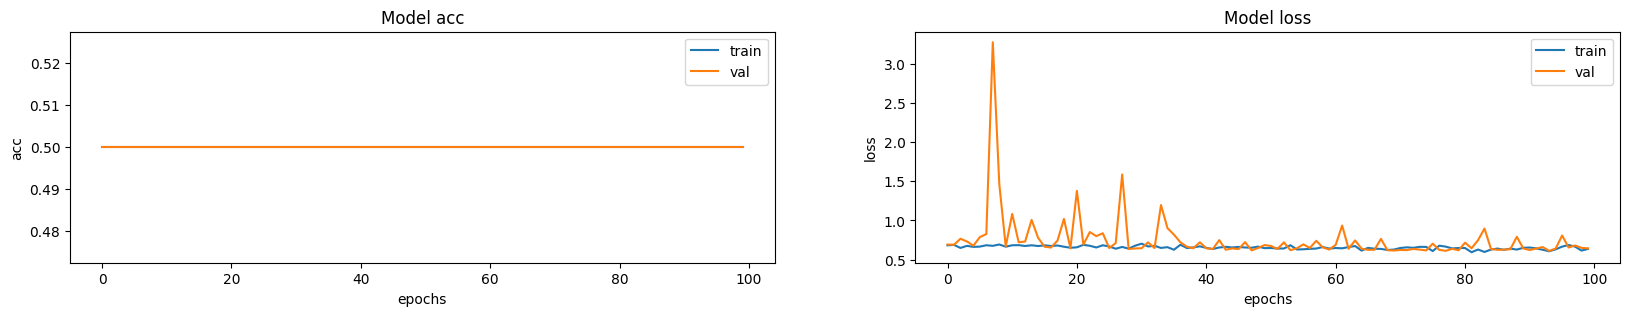

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [47]:
model.load_weights("3DClassification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 0.00 percent confident that CT scan is normal
This model is 100.00 percent confident that CT scan is abnormal


### Retrain from Checkpoint
Just retraining it for 20 more epochs as a testing procedure. This will not add much due to lower training samples

In [42]:
from tensorflow.keras.models import load_model
filepath = "3DClassification.h5"

In [49]:
new_model = load_model(filepath)

filepath_new = "3DClassification_new.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath_new, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
new_model.fit(train_data, validation_data = valid_data, epochs=20,batch_size = 4, callbacks=callbacks_list)

Epoch 1/20
80/80 [==============================] - ETA: 0s - loss: 0.6657 - acc: 0.5000
Epoch 1: loss improved from inf to 0.66565, saving model to 3DClassification_new.h5
80/80 [==============================] - 13s 157ms/step - loss: 0.6657 - acc: 0.5000 - val_loss: 0.6166 - val_acc: 0.5000
Epoch 2/20
80/80 [==============================] - ETA: 0s - loss: 0.6311 - acc: 0.5000
Epoch 2: loss improved from 0.66565 to 0.63105, saving model to 3DClassification_new.h5
80/80 [==============================] - 12s 154ms/step - loss: 0.6311 - acc: 0.5000 - val_loss: 0.7047 - val_acc: 0.5000
Epoch 3/20
80/80 [==============================] - ETA: 0s - loss: 0.6209 - acc: 0.5000
Epoch 3: loss improved from 0.63105 to 0.62086, saving model to 3DClassification_new.h5
80/80 [==============================] - 12s 154ms/step - loss: 0.6209 - acc: 0.5000 - val_loss: 0.6542 - val_acc: 0.5000
Epoch 4/20
80/80 [==============================] - ETA: 0s - loss: 0.5968 - acc: 0.5000
Epoch 4: loss impr

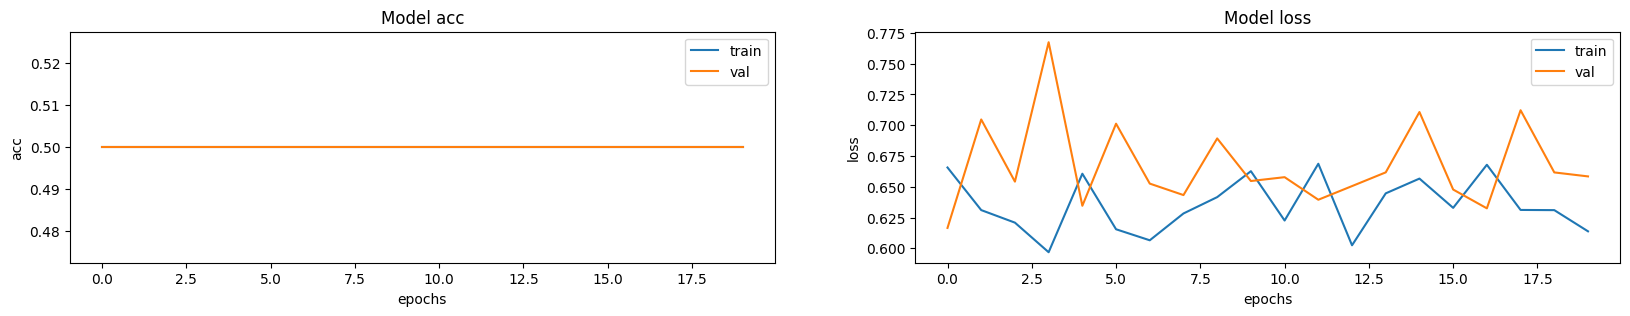

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(new_model.history.history[metric])
    ax[i].plot(new_model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [51]:
new_model.load_weights("3DClassification_new.h5")
prediction = new_model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

This model is 0.00 percent confident that CT scan is normal
This model is 100.00 percent confident that CT scan is abnormal


### With the no. of samples being less, the overall accuracy is not that high as seen from the metrics during training.
This can be improved with more training samples.  In order to do so, we can download the Larger Dataset where there are approx 1000 CT-scans, thus giving the model more samples to learn.